# Covid19 Cases Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from fbprophet import Prophet
import seaborn as sns
from scipy import stats
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### Load and Explore the Data

Loadindg the csv data from local path and creating pandas dataframe

In [0]:
world_df = pd.read_csv('covid-19.csv',parse_dates=['Date'])

In [3]:
world_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


**Dataset Infomation**

*   Id - Serial Number 
*   Province_State - Respective State of the Country
*   Country_Region - Country Name
*   Date : Date(yyy-mm-dd) format
*   ConfirmedCases : Total cases till provided date(It's a cumilative number)
*   Fatalities : Total deaths till provided date(It's a cumilative number)

In [4]:
world_df.describe()

,Id,ConfirmedCases,Fatalities
count,27231.000000,27231.000000,27231.000000
mean,17828.000000,1372.808050,75.991444
std,10300.673333,9488.242361,808.719059
min,1.000000,0.000000,0.000000
25%,8914.500000,0.000000,0.000000
50%,17828.000000,2.000000,0.000000
75%,26741.500000,138.000000,1.000000
max,35655.000000,230597.000000,22745.000000


In [5]:
world_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27231 entries, 0 to 27230
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              27231 non-null  int64         
 1   Province_State  11571 non-null  object        
 2   Country_Region  27231 non-null  object        
 3   Date            27231 non-null  datetime64[ns]
 4   ConfirmedCases  27231 non-null  float64       
 5   Fatalities      27231 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [6]:
world_df.isnull().values.any()

True

In [7]:
world_df.isnull().sum()

Id                    0
Province_State    15660
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

### Preprocessing the data

Only Province_State column has 15660 NAN values.There are multiple approaches to fill the values. Replacing NAN values with blank as data is partially available in this column

In [0]:
world_df.fillna({'Province_State': ""},inplace=True)

### Data Visualizations

Total world wide Covid-19 cases and deaths representation

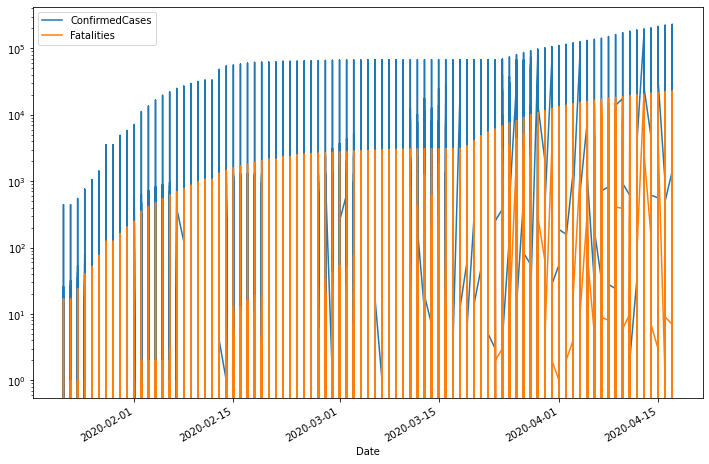

In [9]:
axis = world_df[['Date','ConfirmedCases','Fatalities']].set_index('Date').plot(figsize=(12, 8),logy=True)
plt.show()

In [0]:
def mostEffectedCountries(world_df):
  """
  The function displays most effected countries in descending order. 

        Parameters: 
            world_df (DataFrame): The Dataframe to be processed       
        Returns: 
            country_df: A Dataframe which contains most effected countries cases sum
  """
  country_df = world_df.groupby('Country_Region')['ConfirmedCases'].sum().reset_index()
  country_df.sort_values(["ConfirmedCases"],ascending=False,inplace=True)
  return country_df


In [0]:
country_df = mostEffectedCountries(world_df)

Total 10 hostspots of covid19 cases

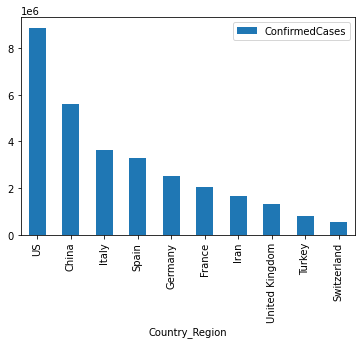

In [12]:
top_count = 10
country_df[:top_count].plot.bar(x='Country_Region',y = 'ConfirmedCases');

In [0]:
def ConfirmedCasesStateWise(df,country):
  """
  This functions displays confirmed cases with county and statewise groping

  Parameters
    df (dataframe) : The dataframe to be processed
    country (str) : Should be valid county name
  Returns:  
    state_df (dataframe) - Returns most corona confirmed cases statewise data
  """
  country_df = df[df.Country_Region == country][['Province_State','ConfirmedCases']]
  state_df = country_df.groupby('Province_State')['ConfirmedCases'].sum().reset_index()
  state_df.sort_values('ConfirmedCases',ascending=False,inplace=True)
  return state_df 

In [0]:
def FatalitiesStateWise(df,country):
  """
  This functions displays death cases with county and statewise groping

  Parameters
    df (dataframe) : The dataframe to be processed
    country (str) : Should be valid county name
  Returns:  
    state_df (dataframe) - Returns most corona confirmed cases statewise data
  """
  country_df = df[df.Country_Region == country][['Province_State','Fatalities']]
  state_df = country_df.groupby('Province_State')['Fatalities'].sum().reset_index()
  state_df.sort_values('Fatalities',ascending=False,inplace=True)
  return state_df

Total 10 hostspot cases states of covid19 cases within US

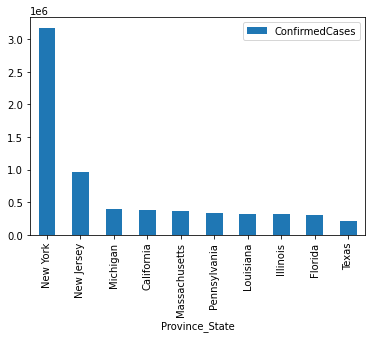

In [15]:
#Funtion works for any valid county code/name within the dataset
country = 'US'
state_df = ConfirmedCasesStateWise(world_df,country)
state_df[:10].plot.bar(x='Province_State',y = 'ConfirmedCases');

Total 10 Fatalities states of covid19 cases within US

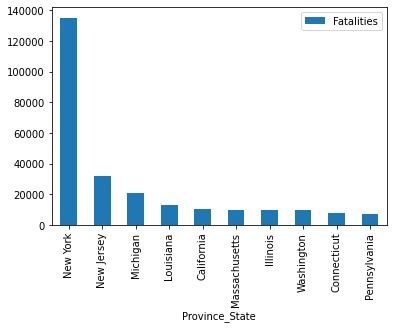

In [16]:
country = 'US'
state_death_df = FatalitiesStateWise(world_df,country)
state_death_df[:10].plot.bar(x='Province_State',y = 'Fatalities');

In [0]:
def countryWisePredictions(df,country):
  """
  This functions prepare data country wise for predictions

  Parameters
    df (dataframe) : The dataframe to be processed
    country (str) : Should be valid county name
  Returns:  
    country_rn_df (dataframe) - Returns most country wise dataset
  """
  country_df = world_df.groupby(['Country_Region','Date'])[['ConfirmedCases','Fatalities']].sum().reset_index()
  country_df = country_df[country_df.Country_Region == country]
  country_rn_df = country_df.rename(columns={"Date":"ds","ConfirmedCases":"y"})
  country_rn_df = country_rn_df.reset_index().drop(["index","Fatalities","Country_Region"],axis= 1)
  return country_rn_df


In [0]:
def stateWisePredictions(df,country,state):
  """
  This functions prepare data state wise for predictions

  Parameters
    df (dataframe) : The dataframe to be processed
    country (str) : Should be valid county name
    state (str) : Should be valid state name
  Returns:  
    state_rn_df (dataframe) - Returns most state wise dataset
  """
  state_df = df[(df["Country_Region"]==country) & (df["Province_State"]==state)][["Date","ConfirmedCases"]]
  state_rn_df = state_df.rename(columns={"Date":"ds","ConfirmedCases":"y"})
  state_rn_df = state_rn_df.reset_index().drop("index",axis= 1)
  return state_rn_df

### Train and Test data split

In [0]:
def train_test_data_split(df,period=5):
  """
  This functions prepare train test data split

  Parameters
    df (dataframe) : The dataframe to be processed
    period (int) : Test dataset size(default is 5 days)
  Returns:  
    train_data (dataframe) - train set to train the model
    test_data (dataframe) -  test set to train the model
  """
  train_data = df[:-period]
  test_data =  df[-period:]
  return train_data,test_data

### Prophet Model Training

In [0]:
def modeling(train_data):
  """
  This functions helps in build and deploy the model

  Parameters
    train_data (dataframe) : train set to train the model
  Returns:  
    pm (prophet object) -  prophet object to run the predictions
  """
  pm = Prophet(changepoint_prior_scale=0.95,interval_width=1)
  pm.fit(train_data)
  return pm

### Predictions

In [0]:
def predictions(pm,periods=5):
  """
  This functions helps in run the predictions

  Parameters
    pm (prophet object) -  prophet object to run the predictions
    periods(int) - Number of days for predictions
  Returns:  
    pm_forecast (dataframe) -  dataframe with predictions
  """
  future = pm.make_future_dataframe(periods)
  pm_forecast = pm.predict(future)
  return pm_forecast

### Model Evaluation

In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    This functions helps to evaluate the model

    Parameters
      y_true (dataframe) -  test dataset
      y_pred(dataframe) - predicted dataset
    Returns:  
      mape (int) -  integer
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
def main(world_df,countries):
  """
    Main function which helps to run the data preparation,model execution, predictions and evaluations

    Parameters
      world_df (dataframe) -  Dataframe which loaded through csv
      countries (list) - comma seperated list of countries
  """
  for country in countries:
      df = countryWisePredictions(world_df,country)
      train_data,test_data = train_test_data_split(df,5)
      pm = modeling(train_data)
      predictions_df = predictions(pm,5)
      results_df = predictions_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(test_data)
      print(results_df.tail(10))
      fig1 = pm.plot(predictions_df)
      fig1.suptitle(country,verticalalignment='center')
      fig2 = pm.plot_components(predictions_df)
      fig2.suptitle(country,verticalalignment='center')
      print(country+' MAPE: '+str(mean_absolute_percentage_error(results_df['yhat'].iloc[0], results_df['y'].iloc[0])))
      print('\n')

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds          yhat    yhat_lower     yhat_upper        y
0 2020-04-13  83282.687872  79917.835914   87825.213843  83213.0
1 2020-04-14  83562.087199  74915.957290   93503.728675  83306.0
2 2020-04-15  82837.278993  66318.822252  100433.717323  83356.0
3 2020-04-16  83504.304086  62196.252291  110311.511263  83403.0
4 2020-04-17  83500.171389  53616.459542  118541.618796  83760.0


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


China MAPE: 0.08367630072815894


          ds         yhat   yhat_lower   yhat_upper       y
0 2020-04-13  2816.136670  2678.249772  2934.169812  2579.0
1 2020-04-14  2905.181426  2795.034750  3009.702454  2613.0
2 2020-04-15  2999.264625  2862.080752  3133.491171  2643.0
3 2020-04-16  3085.852258  2860.766821  3252.013410  2672.0
4 2020-04-17  3173.303606  2953.442233  3396.651392  2700.0
Thailand MAPE: 8.420637821964084




INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds          yhat    yhat_lower    yhat_upper        y
0 2020-04-13  25251.232894  24337.500309  26041.032590  25667.0
1 2020-04-14  26524.512833  25639.604829  27590.853683  27022.0
2 2020-04-15  27778.315774  26515.379152  29000.243041  28196.0
3 2020-04-16  29117.606407  27441.970646  30523.625109  30796.0
4 2020-04-17  30313.606638  27853.429981  32158.771313  32801.0
Canada MAPE: 1.6465220062708334




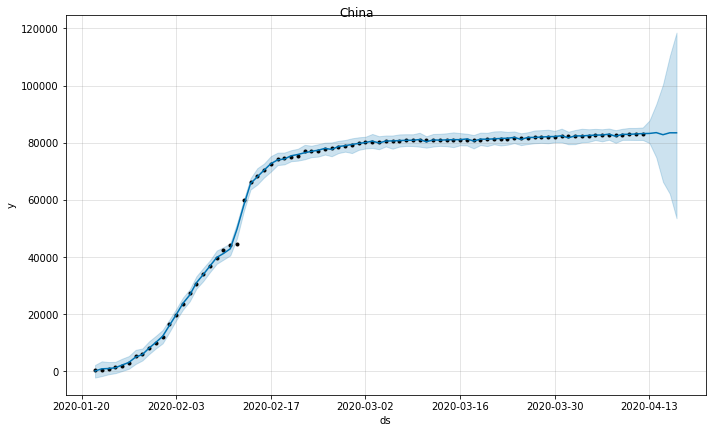

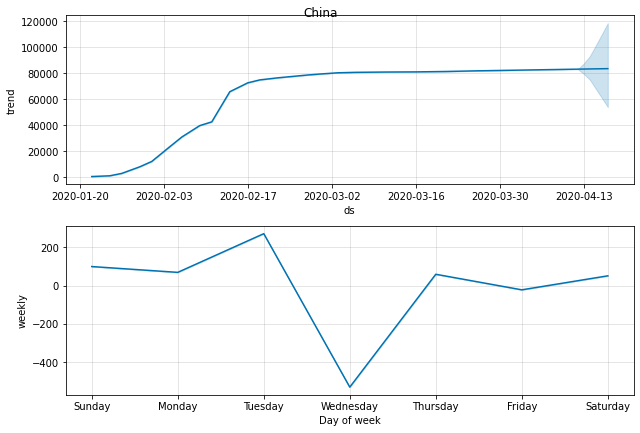

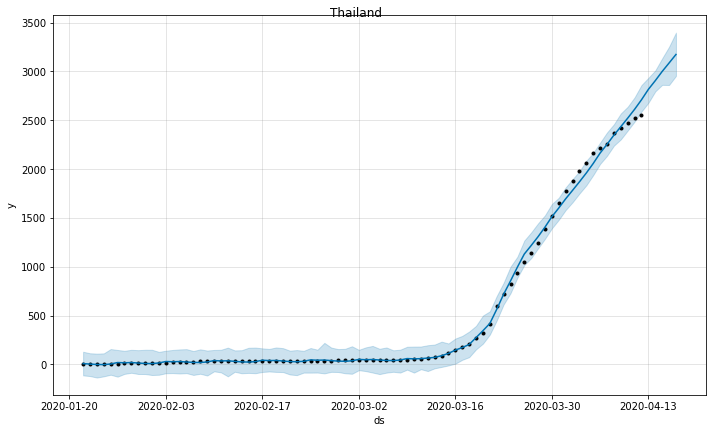

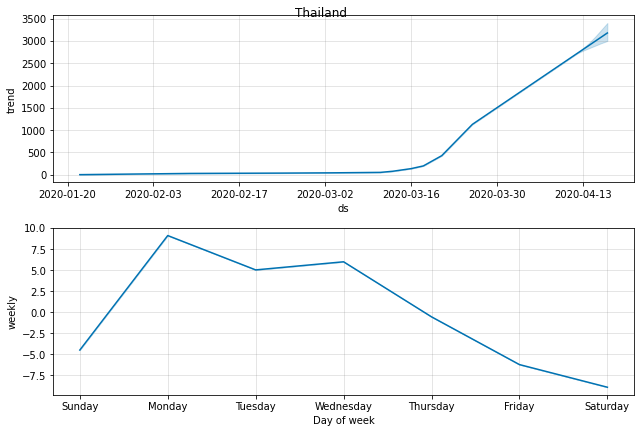

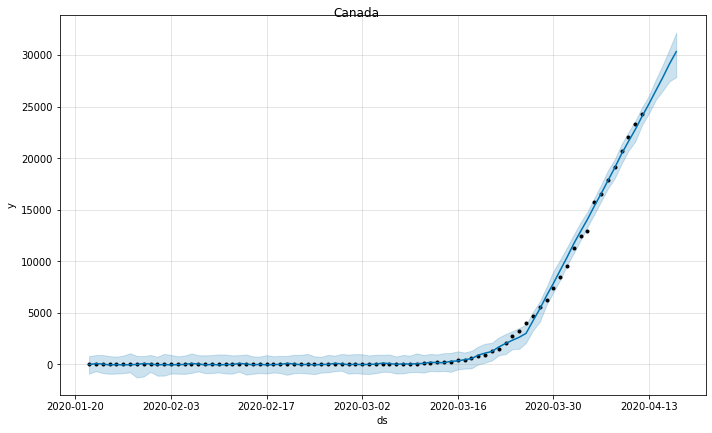

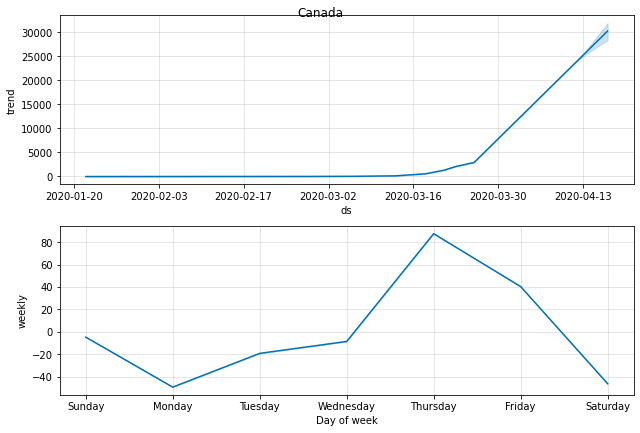

In [24]:
#Comma sepearted list for predictions
countries = ['China','Thailand','Canada']
main(world_df,countries)